## **2. Lasso Regression **

the optimal training/testing splitting ratio is , where  is the number of parameters in a linear regression model that explains the data well.

In [6]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
# from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    )

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import f_classif, SelectFromModel, RFECV
from fast_ml.feature_selection import get_correlated_pairs



In [3]:
file_name = 'DATASET_THESIS_2022.csv'

df_data = pd.concat([chunk for chunk in tqdm(pd.read_csv(file_name, chunksize=1000), desc='Loading data')])

feat_names = [col.replace(' ', '') for col in df_data.columns]
df_data.columns = feat_names
feat_names.remove('TARGET')
y = df_data.TARGET

X = df_data.drop(columns=['TARGET'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state= 42)

X_train.shape, X_test.shape

Loading data: 154it [00:28,  5.38it/s]


((122744, 842), (30686, 842))

## Regularization path of L1 - Logistic Regression

In [ ]:
%%time 

In [1]:
RFECV(
    estimator= 
)

NameError: name 'X_train' is not defined

In [204]:
best_logit_params = {'C': best_params['C'], 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced'}

logit_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler(with_std= True)),
        ('logit', LogisticRegression(random_state= 43, **best_logit_params))
    ])

logit_pipe.fit(X_train.drop(columns = remove_cols.values), y_train)

roc_auc_score(y_test, logit_pipe.predict_proba(X_test.drop(columns = remove_cols.values))[:,1])


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7601723063074673

### Preprocessing : Feature selection based on ANOVA F-value and correlation pairs

In [7]:
imp = SimpleImputer(strategy = 'median').fit(X_train)
X_train_copy = imp.transform(X_train.copy(deep = True))
f_vals =f_classif(X_train_copy, y_train)

feat_anova = pd.DataFrame(
    data = {'feat_names': feat_names, 'f_vals':  f_vals[0]}
).set_index('feat_names')

high_corr_pairs = get_correlated_pairs(X_train, threshold=0.70)

remove_cols = high_corr_pairs.apply(
    lambda r: r['feature2'] if feat_anova.at[r['feature1'], 'f_vals'] > feat_anova.at[r['feature2'], 'f_vals']
        else  r['feature1'], axis =1
        ).drop_duplicates()


#### Hyperopt tuning C

In [ ]:
# Domain space
space = {
    'C': hp.loguniform('C', 0.001, 1),
}

def objective_function(params):

    logit_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler(with_std= True)),
        ('logit', LogisticRegression(
            random_state= 43, penalty = 'l1', solver = 'saga', C = params['C'], max_iter = 2000))
    ])

    cross_val = cross_val_score(
        logit_pipe, X_train.drop(columns = remove_cols.values), y_train, 
        cv = StratifiedKFold(n_splits= 5, shuffle =True), scoring ='roc_auc', n_jobs= 5
        )
        
    loss_mean = cross_val.mean()
    loss_std = cross_val.std()
    
    return {'loss': -loss_mean, 'loss_std': loss_std, 'status': STATUS_OK}

# Optimization algorithm
tpe_algorithm = tpe.suggest

# Result history 
trials = Trials()
num_eval = 20

best_params = fmin(
    objective_function, space, tpe.suggest, max_evals = num_eval, 
    trials = trials
)

pickle.dump(trials, open(DIR + 'trial_results_v0_2.sav', 'wb'))


#### LogisticRegressionCV

In [ ]:

logit_transform_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler(with_std= True))
    ])

X_train_copy = logit_transform_pipe.fit_transform(X_train.drop(columns = remove_cols.values))

mdl_logit_cv = LogisticRegressionCV(
    Cs = [0.001, 0.005, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0, 1.3, 1.5, 1.8, 2, 4],
    penalty = 'l1', solver = 'saga', 
    class_weight = 'balanced',
    n_jobs = 5, cv = StratifiedKFold(n_splits= 5, shuffle =True), scoring ='roc_auc', 
    max_iter = 2000,
    random_state= 43
)

mdl_logit_cv.fit(X_train_copy, y_train)


<ErrorbarContainer object of 3 artists>

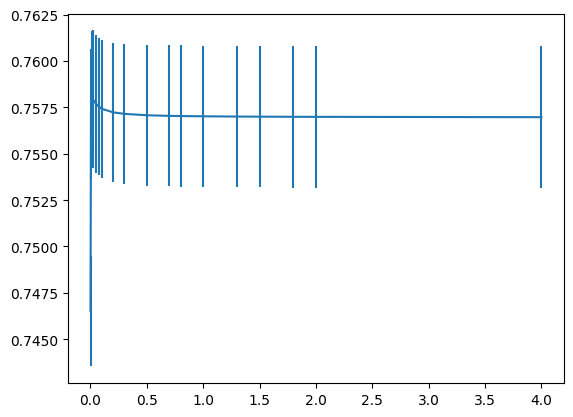

In [148]:
plt.errorbar(
    x = mdl_logit_cv.Cs_,
    y = np.mean(mdl_logit_cv.scores_[1], axis = 0),
    yerr = np.std(mdl_logit_cv.scores_[1], axis = 0)
)

In [167]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import norm

distributions = {'logit__C': norm(loc=0.01, scale=0.003)}

basic_params = {
    'penalty': 'l1',
    'solver': 'saga',
    'class_weight': 'balanced',
    'max_iter': 2000
    }

logit_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler(with_std= True)),
        ('logit', LogisticRegression(random_state= 43, **basic_params))
    ])

cv_random = RandomizedSearchCV(
    logit_pipe, distributions, random_state=43, scoring = 'roc_auc', 
    n_jobs = 5, cv = StratifiedKFold(n_splits= 5, shuffle =True), 
    n_iter = 20
    )
    
cv_random.fit(X_train.drop(columns = remove_cols.values), y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(strategy='median')),
                                             ('scaler', StandardScaler()),
                                             ('logit',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=2000,
                                                                 penalty='l1',
                                                                 random_state=43,
                                                                 solver='saga'))]),
                   n_iter=20, n_jobs=5,
                   param_distributions={'logit__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb89df436a0>},
                   random_state=43, scoring='roc_auc')

In [198]:

feat_names_1 = X_train.drop(columns = remove_cols.values).columns

selector = SelectFromModel(cv_random.best_estimator_[2], threshold= 1e-3, prefit =True)


In [201]:
roc_auc_score(y_test, cv_random.best_estimator_.predict_proba(X_test.drop(columns = remove_cols.values))[:,1])

0.7601725934903902

In [199]:
selector.get_feature_names_out(feat_names_1).shape

(195,)

In [209]:
cv_random.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_logit__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [221]:
sorted(cv_random.cv_results_, key = lambda v: v['param_logit__C'].data)

TypeError: string indices must be integers

<ErrorbarContainer object of 3 artists>

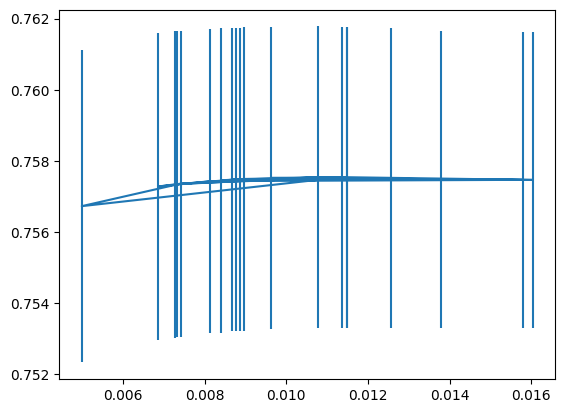

In [216]:
plt.errorbar(
    x = cv_random.cv_results_['param_logit__C'].data,
    y = cv_random.cv_results_['mean_test_score'],
    yerr =  cv_random.cv_results_['std_test_score']
)

<AxesSubplot: xlabel='C', ylabel='AUC'>

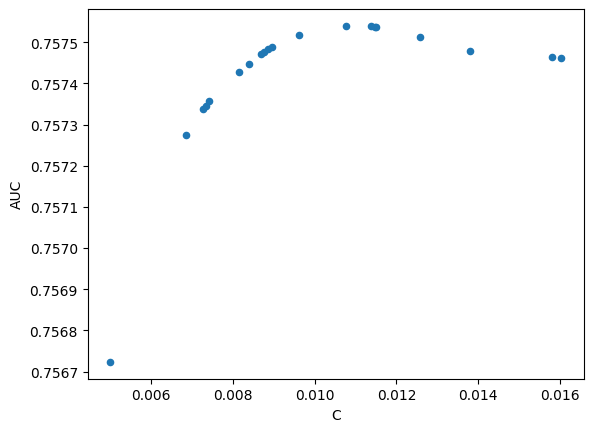

In [168]:
pd.DataFrame(
    data ={
        'C': cv_random.cv_results_['param_logit__C'], 
        'AUC': cv_random.cv_results_['mean_test_score']
        }).plot(x = 'C', y ='AUC', kind = 'scatter')

<AxesSubplot: xlabel='C', ylabel='AUC'>

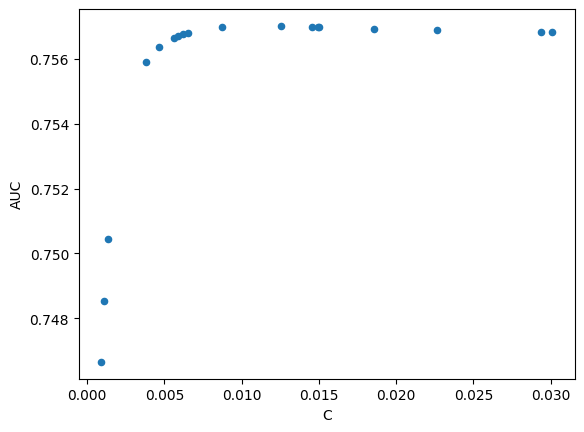

In [166]:
pd.DataFrame(
    data ={
        'C': cv_random.cv_results_['param_logit__C'], 
        'AUC': cv_random.cv_results_['mean_test_score']
        }).plot(x = 'C', y ='AUC', kind = 'scatter')

In [38]:
trials = pickle.load(open(DIR + 'trial_results_v0_1.sav', 'rb'))

In [84]:
df_trials = pd.DataFrame([val['result'] for val in trials.trials])
df_trials['vals'] =[val['misc']['vals']['C'][0] for val in trials.trials]
df_trials['vals'] = df_trials['vals'].apply(lambda r: round(r, 4))

In [85]:
df_trials

,loss,loss_std,status,vals
0,-0.756964,0.003376,ok,2.2815
1,-0.757536,0.003924,ok,1.0805
2,-0.757418,0.005913,ok,1.7708
3,-0.756930,0.001524,ok,1.5662
4,-0.757802,0.001934,ok,2.4505
5,-0.757348,0.004328,ok,2.0492
6,-0.757336,0.002690,ok,1.3352
7,-0.757440,0.006778,ok,1.7345
8,-0.757486,0.007331,ok,1.7629
9,-0.757810,0.005660,ok,2.3433


In [81]:
df_trials

,loss,loss_std,status,vals
0,-0.756776,0.003804,ok,51.0321
1,-0.757286,0.003993,ok,38.3729
2,-0.757340,0.007487,ok,2616.9450
3,-0.757534,0.005753,ok,1313.5652
4,-0.757884,0.004417,ok,26.3295
5,-0.757687,0.003989,ok,3.4261
6,-0.757860,0.003032,ok,26.8318
7,-0.757497,0.003098,ok,59.1785
8,-0.756766,0.001636,ok,3356.2938
9,-0.757597,0.002665,ok,21.8549
